\begin{center}
Gabe Morris
\end{center}

In [1]:
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
from msu_esd import cross_flow_unmixed
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('../maroon.mplstyle')

\pagebreak
\tableofcontents
\pagebreak

# Given
The preliminary design of a recovery heat exchanger for a Solar Turbines Centaur 50 is to be accomplished. The heat exchanger is to be used to heat water from the turbine exhaust for process use. Surface 8.0-3/8T or surface 9.29-0.737-SR is to be used. More information on the Centaur 50 may be found [here](https://s7d2.scene7.com/is/content/Caterpillar/CM20150703-52095-37893).

The requirements are:

| Property                    | Gas Side    | Water Side  |
|-----------------------------|-------------|-------------|
| $\dot{m}\,(\frac{lbm}{hr})$ | 151,410     | 36,000      |
| $T_{in}\,(^\circ F)$        | 910         | 70          |
| $T_{out}\,(^\circ F)$       | 400         | ?           |
| $P_{in}$                    | atmospheric | atmospheric |

The heat exchanger can have necessary width, but the gas inlet side must be such that the Reynolds number inside the finned-tube is about 1000. Water flows through the tubes, which are manifolded together in such a fashion that the water velocity is 3 ft/sec in order to ensure turbulent flow. The properties of the exhaust gas from the heat recovery are close to the properties of air at the same temperature.

# Find
Select the better surface based on economy of the operation by calculating (a) the heat exchanger width and volume for both surfaces, (b) the gas side pressure drop for both surfaces, and (c) the operating costs for both surfaces for 8760 hr/yr operation. Electricity costs $\frac{\$0.05}{kW\,hr}$ for usage and $\frac{\$9}{kW}$ for demand (per month). The fan is 75% efficient.

The surface selected must be clearly indicated in the report. A sketch of the selected configuration, with dimensions indicated should be included.

# Solution
## Properties
The first step is to acquire the properties of the air and water. The properties may be taken at the average temperature between the inlet and exiting temperatures.

### Air
The average temperature of the air is $655\,^\circ F$. The following properties may be obtained from Table B-2 in the text: $\rho=0.03554\,\frac{lbm}{ft^3}$, $c_p=0.25165\,\frac{Btu}{lbm\,^\circ F}$, $\mu=2.077\cdot10^{-5}\,\frac{lbm}{ft\,sec}$, $Pr=0.68775$.

### Water
For water, the exit temperature is not known, but it may be solved for using an iterative process. First, the rating must be solved for using the known values for the air properties.

In [2]:
# Input parameters of air
mdot_a = 151_410  # lbm/hr
Tin_a = 910  # F
Tout_a = 400  # F
cp_a = 0.25165  # btu/(lbm F)

# Getting the rating
q = mdot_a*cp_a*(Tin_a - Tout_a)
q  # Btu per hour

19432186.514999997

Now the exiting temperature may be solved using some python magic.

In [3]:
# Input parameters of water
mdot_w = 36_000  # lbm/hr
Tin_w = 70  # F

# We can get cp as a function of temperature using an interpolation function from scipy
# From the book,
T_values = [80, 90, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600]
cp_values = [0.998, 0.997, 0.998, 1, 1, 1.01, 1.03, 1.05, 1.08, 1.12, 1.19, 1.31, 1.51]

cp_w_lamb = interp1d(T_values, cp_values, fill_value='extrapolate')

Now `cp_w_lamb` may take in arguments at any temperature. This feature will be used later when accessing the database. For instance, the heat capacity should be between 1.08 and 1.12 for $410\,^\circ F$

In [4]:
float(cp_w_lamb(410))  # adding float() because it returns an array

1.088

Now `fsolve` may be used to iteratively find the outlet temperature.

In [5]:
# Getting the outlet temperature
def get_T(Tout_water):
    T_avg = (Tout_water + Tin_w)/2
    cp_water = float(cp_w_lamb(T_avg))
    return q - mdot_w*cp_water*(Tout_water - Tin_w)  # expression equal to zero

Tout_w = fsolve(get_T, np.array([500, ]))[0]
Tout_w  # F

588.2044624423871

With the average temperature of the water being $329.10223\,^\circ F$, the properties from Table B-2 are: $\rho=56.31\,\frac{lbm}{ft^3}$, $c_p=1.0416\,\frac{Btu}{lbm\,^\circ F}$, $\mu=0.114\cdot10^{-3}\,\frac{lbm}{ft\,sec}$, $Pr=1.087$, $k_w=0.393\,\frac{Btu}{hr\,ft\,^\circ F}$.

## Heat Exchanger Conductance
The heat exchanger conductance may be calculated using the NTU method.

In [6]:
# Calculating the conductance
cp_w = 1.0416  # Btu/(lbm F)

Cc = mdot_w*cp_w  # Btu/(hr F)
Ch = mdot_a*cp_a  # Btu/(hr F)
C_min, C_max = min([Cc, Ch]), max([Cc, Ch])
C = C_min/C_max
print(f'C: {C:.3f}')
q_max = C_min*(Tin_a - Tin_w)  # Btu/hr
eff = q/q_max
print(f'Effectiveness: {eff:.3f}')
ntu = cross_flow_unmixed(eff, C)
UA = ntu*C_min  # Btu/(hr F)
print(f'UA: {UA:.3f} Btu/(hr F)')

C: 0.984
Effectiveness: 0.617
UA: 74166.055 Btu/(hr F)


The conductance of the iteration for the heat exchangers need to match the one calculated above as well as possible.

\begin{center}
\includegraphics{images/fig1}  \\
Figure 1: Fin-Tube Heat Exchanger
\end{center}

The conductance for an iteration depending on the geometry of the heat exchanger may be obtained by calculating the resistances for the air side and water side portions of the heat exchanger. The following relationship is,

$$UA_{iter}=\frac{1}{R_a+R_w}$$

## Surface 9.29-0.737-SR
A graphical representation of the relationship between $Re$ and $StPr^{2/3}$ may be acquired from the database. This relationship will be used to obtain the heat convection coefficient for the airside.

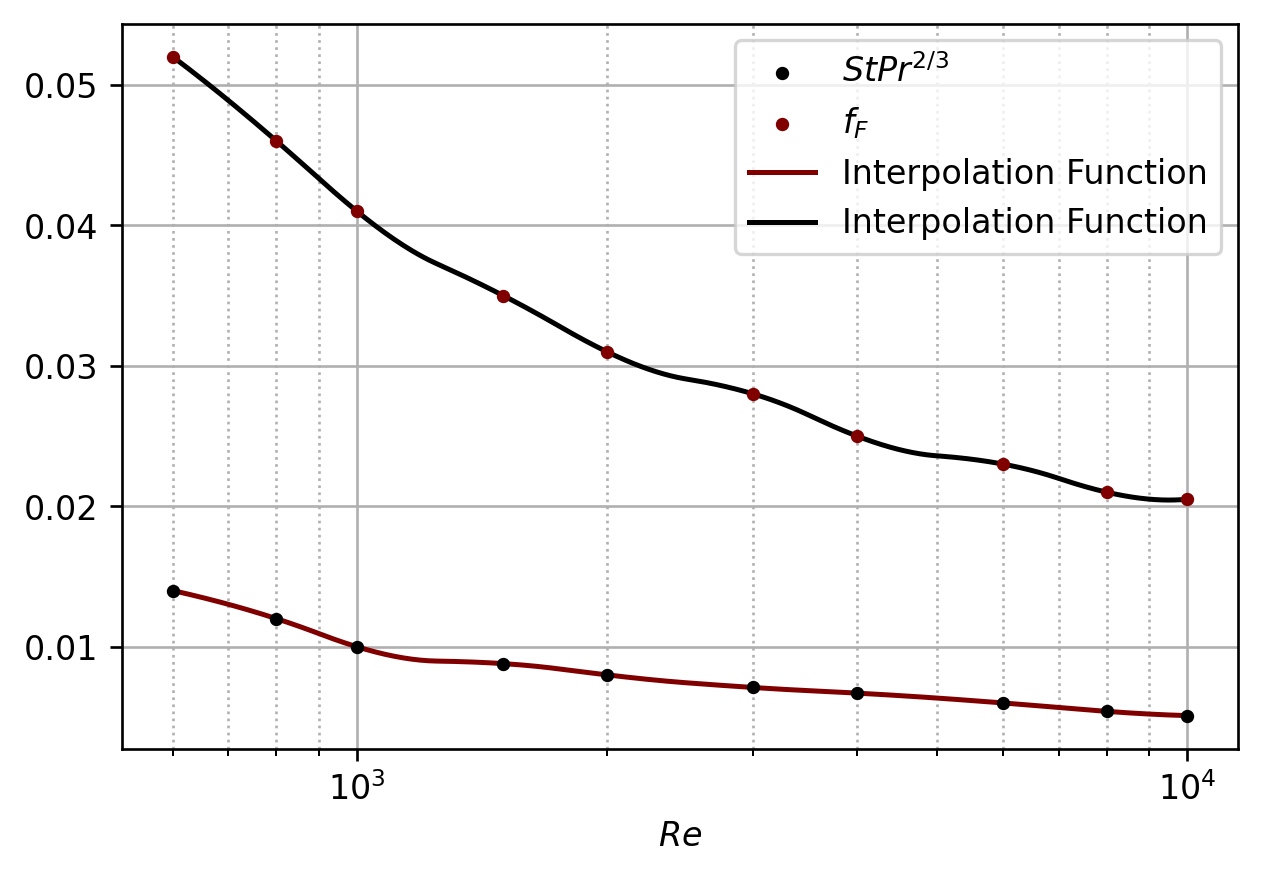

In [7]:
# Getting graph
Re = np.array([600, 800, 1000, 1500, 2000, 3000, 4000, 6000, 8000, 10_000])
hts = np.array([0.014, 0.012, 0.01, 0.0088, 0.008, 0.0071, 0.0067, 0.006, 0.0054, 0.0051])
fF = np.array([0.052, 0.046, 0.041, 0.035, 0.031, 0.028, 0.025, 0.023, 0.021, 0.0205])
hts_lamb = interp1d(Re, hts, kind='quadratic')
fF_lamb = interp1d(Re, fF, kind='quadratic')
Re_values = np.linspace(Re[0], Re[-1], 1000)

plt.scatter(Re, hts, label='$StPr^{2/3}$', zorder=3, marker='.', color='black')
plt.scatter(Re, fF, label='$f_F$', zorder=3, marker='.', color='maroon')
plt.plot(Re_values, hts_lamb(Re_values), label='Interpolation Function', zorder=2)
plt.plot(Re_values, fF_lamb(Re_values), label='Interpolation Function', zorder=2)
plt.xscale('log')
plt.xlabel('$Re$')
plt.grid(which='minor', ls=':')
plt.legend()
plt.show()

### Airside
For the airside (fins), the resistance may be found using,

$$R_a=\frac{1}{\eta_tAh_a}$$

The first step is to calculate $Re$ and making sure that it is around 1000.

In [8]:
# Air properties
rho_a = 0.03554 # lbm/ft^3
mu_a = 2.077e-5 # lbm/(ft sec)
cp_a = 0.25165 # Btu/(lbm F)
Pr_a = 0.68775
mdot_a = 151_410/3600 # lbm/sec

# Find the velocity of the air then use that to find Re
L2 = L3 = 70.71875/12 # ft
L1 = 6.90625/12 # ft
vol = L1*L2*L3 # ft^3
print(f'Volume: {vol:.3f} ft^3')
Da = 0.01352 # ft (from database)
sigma = 0.788 # from database
Va = mdot_a/(L2*L3*sigma*rho_a) # ft/sec
print(f'Velocity: {Va:.3f} ft/s')
G = Va*rho_a
Re_a = G*Da/mu_a
print(f'Re: {Re_a:.3f}')

Volume: 19.988 ft^3
Velocity: 43.242 ft/s
Re: 1000.367


With $Re$ known, the convection may now be solved using,

$$StPr^{2/3}=\frac{h}{G\cdot c_{p,a}}Pr^{2/3}\rightarrow h=\frac{StPr^{2/3}\cdot G\cdot c_{p,a}}{Pr^{2/3}}$$

In [9]:
h_a = hts_lamb(Re_a)*G*cp_a/(Pr_a**(2/3))
h_a  # Btu/(s ft^2 F)

0.004962158851250238

The total fin efficiency may be determined using,

$$\eta_t=1-\frac{A_{fin}}{A_{tot}}(1-\eta_{fin})$$

In [10]:
alpha = 228 # ft^2/ft^3
A_ratio = 0.814
A = alpha*vol # ft^2
L_fin = 0.01875 # ft
k_fin = 221/3600 # Btu/(sec ft F)
t_fin = 0.004/12 # ft
m = np.sqrt(h_a*2/(k_fin*t_fin))
eta_fin = np.tanh(m*L_fin)/(m*L_fin)
print(f'Fin Efficiency: {eta_fin:.3f}')
eta_t = 1 - A_ratio*(1 - eta_fin)
print(f'Total Efficiency: {eta_t:.3f}')
R_fin = 1/(eta_t*A*h_a)
print(f'Resistance: {R_fin:.3f} sec F/Btu')

Fin Efficiency: 0.947
Total Efficiency: 0.957
Resistance: 0.046 sec F/Btu


### Waterside
The resistance from the waterside may be acquired by using,

$$R_w=\frac{1}{h_wA_c}$$

$Re$ may be found first after acquiring the hydraulic diameter, then that could be used to calculate $Nu$. The convection coefficient can then be found using,

$$h_w=\frac{Nu\cdot k_w}{D_h}$$

\begin{center}
\includegraphics{images/fig2} \\
Figure 2: Known Tube Geometry
\end{center}

In [11]:
# Water properties
rho_w = 56.31  # lbm/ft^3
cp_w = 1.0416  # btu/(lbm F)
mu_w = 0.114e-3  # lbm/(ft sec)
Pr_w = 1.087
k_w = 0.393/3600  # btu/(sec ft F)

Dc = 4*0.00306  # ft (from example 3-3)
alpha_c = 42.1  # ft^2/ft^3 (from example 3-3)
sigma_c = 0.129
Vw = 3  # ft/sec
Gw = Vw*rho_w  # lbm/(s ft^2)
Re_w = Gw*Dc/mu_w
print(f"Re: {Re_w:.3f}")

Re: 18137.747


In [12]:
# Since the flow is turbulent,
Nu = 0.023*Re_w**0.8*Pr_w**0.333
print(f'Nu: {Nu:.3f}')
h_w = Nu*k_w/Dc
print(f'h: {h_w:.3f} Btu/(s ft^2 F)')
Ac = alpha_c*vol
print(f'Ac: {Ac:.3f} ft^2')
Rw = 1/(Ac*h_w)
print(f'Resistance: {Rw} F*sec/Btu')

Nu: 60.347
h: 0.538 Btu/(s ft^2 F)
Ac: 841.492 ft^2
Resistance: 0.002207916326276725 F*sec/Btu


In [13]:
# Solving for UA_iter
UA_iter = 1/(Rw + R_fin)*3600
print(f'UA_iter: {UA_iter:.3f} Btu/(hr F)')
print(f'UA_iter/UA: {UA_iter/UA:.3f}')

UA_iter: 74332.967 Btu/(hr F)
UA_iter/UA: 1.002


Thus, the final dimensions of the heat exchanger are $L_1=6\frac{29}{32}\,in$ (width) and $L_2=L_3=70\frac{23}{32}\,in$.

### Airside Pressure Drop
The relationship for the pressure drop is,

$$\Delta P=\frac{G^2}{2\rho_{a,in}}\left[(K_c+1-\sigma^2)+2\left(\frac{\rho_{a,in}}{\rho_{a,out}}-1\right)+f_F\frac{A}{A_c}\frac{\rho_{a,in}}{\rho_{a,mean}}-(1-\sigma^2-K_e)\frac{\rho_{a,in}}{\rho_{a,out}}\right]$$

\begin{center}
\includegraphics{images/fig3} \\
Figure 3: $K_c$ and $K_e$
\end{center}

The constants $K_c$ and $K_e$ may be acquired from Figure 3. Although the curves above are for square tube geometry, the assumption is that surface 9.29-0.737-SR is similar.

In [14]:
# Obtain air properties
rho_a_in = 0.0289  # lbm/ft^3 at 910 F
rho_a_out = 0.046  # lbm/ft^3 at 400 F
rat = rho_a_in/rho_a_out

# From figure above
Kc, Ke = 0.95, -0.55

x1 = Kc + 1 - sigma**2
x2 = 2*(rat - 1)
x3 = float(fF_lamb(Re_a))*A/(L2*L3*sigma)*rho_a_in/rho_a
x4 = (1 - sigma**2 - Ke)*rat

del_P = G**2/(2*rho_a_in)*(x1 + x2 + x3 - x4)/32.174
del_P  # lbf/ft^2

7.051894839766607

Thus, the pressure drop across the airside is around $7.05\,\frac{lbf}{ft^2}$.

### Power Consumption
The power consumption for the fan may be calculating using,

$$power=\frac{Q\Delta P}{\eta}$$

where $\eta$ is the efficiency and $Q=\frac{\dot{m}}{\rho}$.

In [15]:
# Calculating the power
eta = 0.75
Q_a = mdot_a/rho_a  # ft^3/s
power = Q_a*del_P/eta
power_kW = power*0.00135581795
print(f'Power: {power:.3f} ft*lbf/s = {power/550:.3f} hp = {power_kW:.3f} kW')

Power: 11127.028 ft*lbf/s = 20.231 hp = 15.086 kW


The relationship for power and cost is,

$$cost\ per\ year=\frac{\$0.05}{kW\,hr}\frac{8760\,hr}{yr}\cdot power+\frac{\$9}{kW\,mo}\frac{12\,mo}{yr}\cdot power$$

where the power is in kilowatts.

In [16]:
# Calculating the cost per year
cost_per_year = 0.05*8760*power_kW + 9*12*power_kW
print(f'Cost Per Year: ${cost_per_year:.2f}/year')

Cost Per Year: $8237.08/year


The operating cost of the 9.29-0.737-SR surface is $8237.08/year.